# QAOA for random bond Ising model (RBIM)

In [1]:
import qaoa
import qucompsys as qucs
import graphs as gr
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools
from collections import Counter

import importlib
importlib.reload(qaoa)
importlib.reload(qucs)

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

##  0 Define the graph

In [2]:
# grid graph
n_nodes = 4
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

In [117]:
# grid graph
n_nodes = 9
nodes = np.arange(0, n_nodes, 1)
edges = [(0, 1), (0,3), (1, 2), (1, 4), (2, 5), (3,4), (3,6), (4, 5), (4, 7), (5,8), (6, 7), (7, 8)]

In [118]:
n_qubits = n_nodes
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
edges = list(graph.edges)

### 0.1 plot the graph

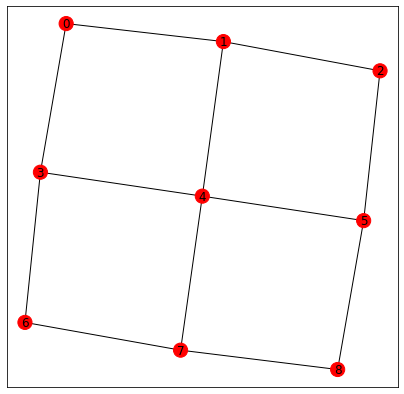

In [119]:
fig = plt.figure(figsize = (7,7))
colors = ['r' for node in graph.nodes()]
pos = nx.planar_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, pos = None, alpha=1, with_labels=True)
plt.show()

## 1 choose probability

In [120]:
prob = 1 #prbability 0.5 < prob < 1 that the site is ferromagnetic (all 1 or -1), expect phase-transistion at p = 0.88

bin_prob_dist = np.random.binomial(1, prob, size=(len(edges),)) # 1 for ferromagnetic link

bin_prob_dist

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [121]:
for i, link in enumerate (bin_prob_dist):
    if link == 0:
        bin_prob_dist[i] = -1
bin_prob_dist

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## 2 Define needed functions

In [7]:
def evaluate_energy_ising(list_z, edges, bin_prob_dist, coupling_const=1):
    """This method evaluates the object function of the RBIM
    Parameters
        z_str : input bit string
        edges : edges of the graph
    Returns
        the integer value the object function"""
    energy = 0
    for i, edge in enumerate(edges):
        energy += -bin_prob_dist[i]*list_z[edge[0]]*list_z[edge[1]]
    return coupling_const*energy

In [8]:
all_outcomes = itertools.product([1,-1], repeat=n_qubits)
for outcome in all_outcomes:
    print(outcome, evaluate_energy_ising(outcome, edges, bin_prob_dist))

(1, 1, 1, 1) -4
(1, 1, 1, -1) 0
(1, 1, -1, 1) 0
(1, 1, -1, -1) 0
(1, -1, 1, 1) 0
(1, -1, 1, -1) 4
(1, -1, -1, 1) 0
(1, -1, -1, -1) 0
(-1, 1, 1, 1) 0
(-1, 1, 1, -1) 0
(-1, 1, -1, 1) 4
(-1, 1, -1, -1) 0
(-1, -1, 1, 1) 0
(-1, -1, 1, -1) 0
(-1, -1, -1, 1) 0
(-1, -1, -1, -1) -4


In [114]:
def evaluate_magnetization_ising(list_z):
    """This method evaluates the object function of the RBIM
    Parameters
        z_str : input bit string
        edges : edges of the graph
    Returns
        the integer value the object function"""

    return abs(sum(list_z))

for prob=1 (all links are ferromagnetics), we have that $H = -J\sum_{<u,v>}Z_uZ_v$, and we know that it's analitical expression is:

$$E_1(\gamma,\beta) = \langle H_{Ising} \rangle = \sum_{<u,v>} C_{<u,v>} = \sum_{<u,v>} 
+ \frac{1}{2} (sin4\beta sin2\gamma)(cos^{d_u}\gamma + cos^{d_v}\gamma) - \frac{1}{2}(sin^2\beta cos^{d_u + d_v - 2\lambda_{uv}}\gamma)(1-cos^{\lambda_{uv}}2\gamma)$$

In [10]:
def analitic_E_1(parameters, graph, edges):
    f_1 = 0
    gamma = parameters[0]
    beta = parameters[1]
    for edge in edges:
        degree_u = gr.node_degree(graph, edge[0])
        degree_v = gr.node_degree(graph, edge[1])
        lambda_uv = gr.common_neighbours(graph, edge[0], edge[1])
        c_uv = +0.5*np.sin(4*beta)*np.sin(gamma)*(np.cos(gamma)**(degree_u-1) + np.cos(gamma)**(degree_v-1))
        -0.5*np.sin(beta)**2*np.cos(gamma)**(degree_u+degree_v-2-2*lambda_uv)*(1-np.cos(2*gamma)**lambda_uv)
        f_1 += c_uv
    return f_1

In [11]:
scipy.optimize.minimize(analitic_E_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')

 final_simplex: (array([[ 0.78536687, -0.39267054],
       [ 0.78529206, -0.39268441],
       [ 0.78543974, -0.39276145]]), array([-1.99999998, -1.99999995, -1.99999993]))
           fun: -1.9999999830459168
       message: 'Optimization terminated successfully.'
          nfev: 122
           nit: 65
        status: 0
       success: True
             x: array([ 0.78536687, -0.39267054])

In [12]:
optimal_params_scipy = scipy.optimize.minimize(analitic_E_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')['x']
optimal_gamma_scipy = optimal_params_scipy[0]
optimal_beta_scipy = optimal_params_scipy[1]

In [13]:
step_size = 0.01
a_gamma_iter         = np.arange(-np.pi/2, np.pi/2, step_size)
a_beta_iter          = np.arange(-np.pi/4, np.pi/4, step_size)
grid_gammas_betas_iter = list(itertools.product(a_gamma_iter, a_beta_iter))
grid_F_1_iter = []
for par_iter in grid_gammas_betas_iter:
    grid_F_1_iter.append(analitic_E_1(np.reshape(par_iter, (2,1)), graph, edges))

In [14]:
optimal_gamma_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(min(grid_F_1_iter))][0]
optimal_beta_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(min(grid_F_1_iter))][1]

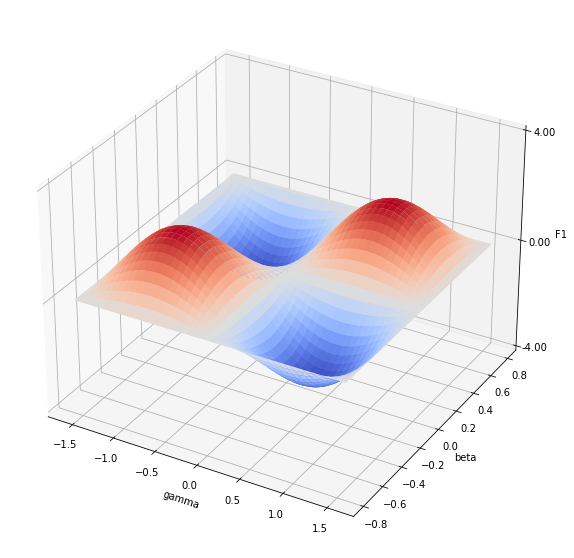


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = -2.000
where the min E is  -4
This is attained for gamma = -0.781 and beta = 0.395


In [15]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')


y_axis, x_axis = np.meshgrid(a_beta_iter, a_gamma_iter)
z_axis = np.reshape(np.array(grid_F_1_iter), y_axis.shape)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)

min_energy = evaluate_energy_ising([1,1,1,1], edges, bin_prob_dist)
ax.set_zlim(min_energy, -min_energy)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amin(z_axis))
print('where the min E is ', min_energy)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_iter, optimal_beta_iter))

In [17]:
def prob_hamilt_ising(n_qubits, edges, bin_prob_dist, coupling_const=1):
    """This method generates a tensor that apply the problem hamiltonian of the
        RBIM problem on a state of n-qubits\n
    Parameters:\n
        n_qubits: number of vertices of the graph
        edges: list of tuples corresponding to the edges of the graph\n
    Returns:\n
        a tensor that apply the problem hamiltonian to a n-qubits state\n
    Raise:\n
        ValueError if number of qubits is less than 2"""
    if n_qubits < 2:
        raise ValueError('number of qubits must be > 1, but is {}'.format(n_qubits))
    list_double_sigmaz = []
    for i, edge in enumerate(edges):
        list_double_sigmaz.append(
            qucs.n_sigmaz(n_qubits,edge[0])*qucs.n_sigmaz(n_qubits,edge[1])#*bin_prob_dist[i]
            ) 
    return -sum(list_double_sigmaz)*coupling_const

In [52]:
def evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist):
    if len(gammas) < 1:
        raise ValueError('number of gammas must be > 0, but is {}'.format(len(gammas)))
    if len(betas) < 1:
        raise ValueError('number of gammas must be > 0, but is {}'.format(len(betas)))
    if len(betas) != len(gammas):
        raise ValueError('number of gammas must be = number of betas')
    if n_qubits < 2:
        raise ValueError('number of qubits must be > 1, but is {}'.format(n_qubits))
    evol_oper = qucs.n_qeye(n_qubits)
    for i in range(len(gammas)):
        u_mix_hamilt_i = (-complex(0,betas[i])*qaoa.mix_hamilt(n_qubits)).expm()
        #u_prob_hamilt_i = (-complex(0,gammas[i])*qaoa.prob_hamilt(n_qubits, edges)).expm()
        u_prob_hamilt_i = (-complex(0,gammas[i])*prob_hamilt_ising(n_qubits, edges, bin_prob_dist)).expm()
        evol_oper = u_mix_hamilt_i*u_prob_hamilt_i*evol_oper
    return evol_oper

In [19]:
def single_qubit_measurement_ising(qstate, qubit_pos):
    n_qubits = len(qstate.dims[0])
    if qstate.dims[1][0] == 1:
        qstate = qu.ket2dm(qstate)
    M_i = (qucs.n_proj0(n_qubits, qubit_pos)*qstate)
    p0_i = M_i.tr()
    #p1_i = (n_proj1(n_qubits, i)*dm_dummy).tr()
    if np.random.random_sample() <= p0_i:
        outcome = [1]
        qstate = M_i/p0_i
    else:
        outcome = [-1]
        qstate = (qucs.n_proj1(n_qubits, qubit_pos)*qstate)/(1-p0_i)
    return outcome, qstate

In [20]:
def quantum_measurements_ising(n_samples, qstate):
    """
    This method simulates n_samples quantum computational basis measurements 
        on a composite system by obtaining, for each sampling, a bit string 
        correspondign to the camputational basis state of the Hilbert space the 
        state belongs to.
    
    Parameters
    ----------
    n_samples : int
        number of samplings want to be executed on the quantum state.
    qstate : Qobj
        pure state or density matrix of a n-qubits state.

    Returns
    -------
    outcomes : list 
        list of outcomes, stored as bit-strings.
    """
    n_qubits = len(qstate.dims[0])
    if qstate.dims[1][0] == 1:
        qstate = qu.ket2dm(qstate)
    outcomes = []
    for j in range(n_samples):
        outcome = []
        qstate_dummy = qstate.copy()
        for i in range(n_qubits):
            outcome_i, qstate_dummy = single_qubit_measurement_ising(qstate_dummy, i)
            outcome += outcome_i
        outcomes.append(outcome)
    return outcomes

In [105]:
def evaluate_energy_p(params, n_qubits, edges, bin_prob_dist, n_samples):
    """
    This method perform n quantum measurements on final state and evaluate F_p
    through classical mean of the outcomes

    Parameters
    ----------
    params : 1-D array-like
        array of parameters [gamma_1, gamma_2, ..., gamma_p, beta_1, beta_2, ..., beta_p].
    n_qubits : int
        number of qubits of the state.
    edges : list of tuples
        edges of the graph.
    n_samples : int
        number of quantum measurements performed.

    Returns
    -------
    F_p: float
        expectation value of the cost function

    """
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    #fin_state = qaoa.evolution_operator(n_qubits, edges, gammas, betas)*init_state

    
    #Perform N measurements on each single qubit of final state
    outcomes = quantum_measurements_ising(n_samples, fin_state)
    dict_outcomes = {}
    for outcome in outcomes:
        dict_outcomes[tuple(outcome)] = outcomes.count(outcome)
    
    #Evaluate Fp
    Ep = 0
    for outcome_w in dict_outcomes:
        Ep += dict_outcomes[outcome_w]*evaluate_energy_ising(outcome_w, edges, bin_prob_dist)
    return Ep/n_samples

In [112]:
def evaluate_magnetization_p(params, n_qubits, edges, bin_prob_dist, n_samples):
    """
    This method perform n quantum measurements on final state and evaluate F_p
    through classical mean of the outcomes

    Parameters
    ----------
    params : 1-D array-like
        array of parameters [gamma_1, gamma_2, ..., gamma_p, beta_1, beta_2, ..., beta_p].
    n_qubits : int
        number of qubits of the state.
    edges : list of tuples
        edges of the graph.
    bin_prob_dist: list
        binary prob dist of type of links
    n_samples : int
        number of quantum measurements performed.

    Returns
    -------
    M_p: float
        expectation value of the cost function

    """
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    
    #Perform N measurements on each single qubit of final state
    outcomes = quantum_measurements_ising(n_samples, fin_state)
    dict_outcomes = {}
    for outcome in outcomes:
        dict_outcomes[tuple(outcome)] = outcomes.count(outcome)
    
    #Evaluate Fp
    Mp = 0
    for outcome_w in dict_outcomes:
        Mp += dict_outcomes[outcome_w]*evaluate_magnetization_ising(outcome_w)
    return Mp/n_samples

## 1 Parameters optimization

## 1.1 Choose QAOA level and pick initial parameters

In [23]:
n_levels = 1

In [109]:
list_init_params = 0.5*np.random.rand(2*n_levels)
list_init_gammas = list_init_params[:n_levels]
list_init_betas = list_init_params[n_levels:]

## 1.2 Generate initial state

${\large |s\rangle = \sum_{z \, \in \, \{0,1\}^n}^{}{|z\rangle} = |+\rangle^{\otimes n}}$

In [24]:
# initial state:
init_state = qaoa.initial_state(n_qubits)
#dm_init_state = qu.ket2dm(qaoa.initial_state(n_qubits))

## 1.3 Obtain final state

${\large |\vec{\gamma},\vec{\beta}\rangle = U(B,\beta_p)U(C,\gamma_p)...U(B,\beta_1)U(C,\gamma_1)|s\rangle}$

In [28]:
# obtain final state:
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
#fin_state = evolution_operator_ising(n_qubits, edges, optimal_gammas, optimal_betas, bin_prob_dist)*init_state
#dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

##  1.4 Perform N-computational_basis measurements on $|\vec{\gamma},\vec{\beta}\rangle$ and evaluate $F_p$

the idea is that, for each ($\gamma,\beta$), after each measurement I will obtain as outcome one of the elements of the computational basis: $\{z : z \in \{ 0,1 \}^n\}$

so, after N measurements, I will have each that each possible outcome $z_i$ has been obtained with occurency $w_i$, so $F_p$ will be evaluated as:

$$F_p = \frac{\sum_{i}^{N}{w_iC(z_i)}}{\sum_{i}^{N}{w_i}}$$

In [29]:
qu.expect(prob_hamilt_ising(n_qubits, edges, bin_prob_dist), fin_state)

-1.9999999830459154

In [38]:
dict_outcomes

{(-1, -1, 1, 1): 5,
 (-1, -1, -1, -1): 30,
 (1, 1, 1, 1): 25,
 (-1, 1, -1, -1): 4,
 (1, -1, -1, 1): 9,
 (-1, 1, 1, -1): 8,
 (1, -1, -1, -1): 3,
 (1, 1, -1, 1): 2,
 (1, 1, -1, -1): 5,
 (1, -1, 1, 1): 1,
 (-1, -1, 1, -1): 2,
 (1, -1, 1, -1): 2,
 (1, 1, 1, -1): 2,
 (-1, 1, 1, 1): 2}

In [47]:
n_samples = 100
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
E_p = evaluate_energy_p(optimal_params, n_qubits, edges, bin_prob_dist, n_samples)
E_p

-2.04

In [62]:
#Perform N measurements on each single qubit of final state
n_sample=100
outcomes = quantum_measurements_ising(1000, fin_state)
dict_outcomes = {}
for outcome in outcomes:
    dict_outcomes[tuple(outcome)] = outcomes.count(outcome)

#Evaluate Fp
Ep = 0
for outcome_w in dict_outcomes:
    Ep += dict_outcomes[outcome_w]*evaluate_energy_ising(outcome_w, edges, bin_prob_dist)
Ep/n_samples

-12.92

In [104]:
#Perform N measurements on each single qubit of final state
n_samples = 1000
outcomes = quantum_measurements_ising(n_samples, fin_state)
dict_outcomes = {}
for outcome in outcomes:
    dict_outcomes[tuple(outcome)] = outcomes.count(outcome)

#Evaluate Fp
Ep = 0
for outcome_w in dict_outcomes:
    Ep += dict_outcomes[outcome_w]*evaluate_energy_ising(outcome_w, edges, bin_prob_dist)
    print(dict_outcomes[outcome_w], outcome_w,evaluate_energy_ising(outcome_w, edges, bin_prob_dist))
Ep/n_samples

259 (1, 1, 1, 1) -4
77 (1, 1, -1, -1) 0
277 (-1, -1, -1, -1) -4
85 (-1, 1, 1, -1) 0
15 (1, 1, -1, 1) 0
12 (1, 1, 1, -1) 0
82 (1, -1, -1, 1) 0
76 (-1, -1, 1, 1) 0
19 (-1, 1, 1, 1) 0
20 (1, -1, 1, -1) 4
18 (-1, 1, -1, 1) 4
18 (-1, -1, -1, 1) 0
8 (1, -1, -1, -1) 0
16 (1, -1, 1, 1) 0
6 (-1, -1, 1, -1) 0
12 (-1, 1, -1, -1) 0


-1.992

In [119]:
all_outcomes = itertools.product([1,-1], repeat=n_qubits)

In [277]:
n_samples = 100
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
E_p = evaluate_energy_p(optimal_params, n_qubits, edges, bin_prob_dist, n_samples)
E_p

0.24

In [134]:
M_p = evaluate_magnetization_p(list_init_params, n_qubits, edges, bin_prob_dist, n_samples)
M_p

-0.06

In [28]:
# obtain final state:
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
#fin_state = evolution_operator_ising(n_qubits, edges, optimal_gammas, optimal_betas, bin_prob_dist)*init_state
#dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

In [97]:
outcomes = quantum_measurements_ising(1000, fin_state)
dict_outcomes = {}
for outcome in outcomes:
    dict_outcomes[tuple(outcome)] = outcomes.count(outcome)

In [99]:
sum(list(dict_outcomes.values()))

1000

<BarContainer object of 16 artists>

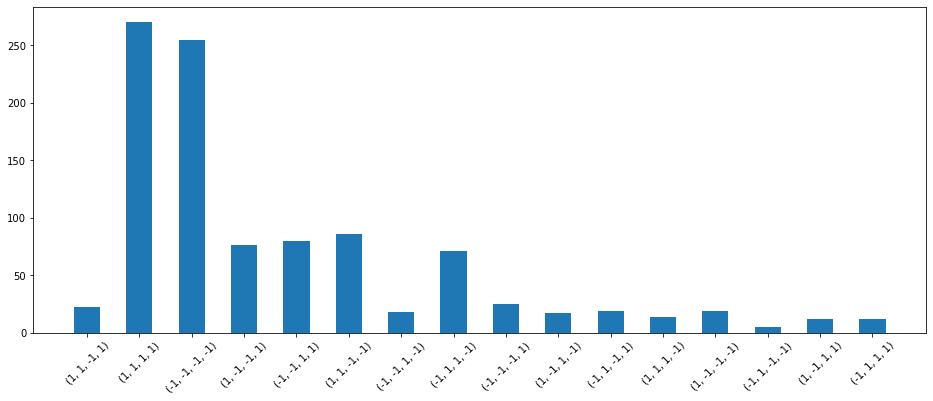

In [98]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits,6))
plt.xticks(rotation=45)
x_axis = []
for key in dict_outcomes:
    x_axis.append(str(key))
plt.bar(x_axis, dict_outcomes.values(), width = 0.5)

### 1.5 Parameters update

In [139]:
# perform M-steps for expectation value of the cost-function
n_steps = 5
n_levels = 1
#parameters = np.array(0.5*np.random.random_sample(2*n_levels))
parameters = 0.01*np.random.rand(2*n_levels)
eta = 0.001 #con 0.01 si muove troppo lentamente, però con 0.1 oscilla troppo attorno al massimo
H_P = prob_hamilt_ising(n_qubits, edges, bin_prob_dist)
for i in range(n_steps):
    g_t = qaoa.fin_diff_grad(evaluate_energy_p, parameters, args=(n_qubits, edges, bin_prob_dist, 100), increment=0.01)
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    E_p = qu.expect(H_P, fin_state)
    parameters = parameters - eta*g_t
    if (i + 1) % 1 == 0:
            print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, E_p))
optimal_parameters = parameters
print('optimal parameters are ', optimal_parameters)

in [0.08897426 0.00602018] with grad  [-88.   0.] objective after step     1:  0.0005630
in [ 0.08897426 -0.01097982] with grad  [ 0. 17.] objective after step     2:  0.0496777
in [ 0.07297426 -0.03097982] with grad  [16. 20.] objective after step     3: -0.0905836
in [0.05297426 0.02602018] with grad  [ 20. -57.] objective after step     4: -0.2115272
in [ 0.05297426 -0.01497982] with grad  [ 0. 41.] objective after step     5:  0.1304894
optimal parameters are  [ 0.05297426 -0.01497982]


In [82]:
#Adam
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_steps = 20
#parameters = np.array(0.5*np.random.random_sample(2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
parameters = 0.01*np.random.rand(2*n_levels)
"""
parameters = np.zeros(2*n_levels) # method used in the paper
for j in range(2*n_levels):
    if j%2 == 0: #for H-p parameters
        parameters[j] = j/(2*n_levels) #see SGD paper for reference
    else:
        parameters[j] = 1 - j/(2*n_levels) #see SDG paper
"""
beta_1 = 0.8
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
H_P = prob_hamilt_ising(n_qubits, edges, bin_prob_dist)
eta = 0.05 #works also for eta = 0.01, but increases very slowly, and 0.1 oscillates too much around max
previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps):
    g_t = qaoa.fin_diff_grad(evaluate_energy_p, parameters, args=(n_qubits, edges, bin_prob_dist, 100), increment=0.1)
    gammas = parameters[:n_levels]
    betas = parameters[n_levels:]
    fin_state = evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state
    E_p_adam = qu.expect(H_P, fin_state)
    #if (np.sign(g_t) == -np.sign(previous_g_t)).all() and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        #break
    #if (i + 1) % 1 == 0:
    print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, E_p_adam))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters - eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #previous_g_t = g_t
optimal_parameters_Adam_fin_diff = parameters
optimal_gammas = optimal_parameters_Adam_fin_diff[:n_levels]
optimal_betas = optimal_parameters_Adam_fin_diff[n_levels:]
print('optimal parameters are ', optimal_parameters_Adam_fin_diff, 'and F_1 is', qu.expect(H_P, evolution_operator_ising(n_qubits, edges, gammas, betas, bin_prob_dist)*init_state)

in [0.0082775  0.00879098] with grad  [1.4 3. ] objective after step     1:  0.0023277
in [-0.0417225  -0.04120901] with grad  [-1.8 -1.8] objective after step     2:  0.0545163
in [-0.03000883 -0.04794691] with grad  [-4.6 -0.4] objective after step     3:  0.0456510
in [ 0.00553882 -0.04875354] with grad  [-4.4  1.4] objective after step     4: -0.0085858
in [ 0.04818291 -0.06184628] with grad  [-2.2  1.2] objective after step     5: -0.0938049
in [ 0.09032736 -0.0816969 ] with grad  [-3.6  2.6] objective after step     6: -0.2269483
in [ 0.13534311 -0.11313271] with grad  [-5.   4.4] objective after step     7: -0.4506337
in [ 0.18388644 -0.15446678] with grad  [-3.4  4. ] objective after step     8: -0.7774085
in [ 0.23251259 -0.2008714 ] with grad  [-1.2  4. ] objective after step     9: -1.1540236
in [ 0.27602701 -0.250481  ] with grad  [-2.2  2. ] objective after step    10: -1.5048275
in [ 0.31836122 -0.29803054] with grad  [-2.8  6. ] objective after step    11: -1.7767608
in 

(None, 'and F_1 is', -1.989826631936847)

In [86]:
qu.expect(H_P, fin_state)

-1.9994763533079125

In [79]:
optimal_parameters_Adam_fin_diff

array([-0.36152294,  0.40566684])

In [75]:
E_p

-2.2

In [109]:
n_samples = 1000
#optimal_params = optimal_params_scipy
optimal_params = optimal_parameters_Adam_fin_diff
E_p = evaluate_energy_p(optimal_params, n_qubits, edges, bin_prob_dist, n_samples)
E_p

-1.904

In [116]:
M_p = evaluate_magnetization_p(optimal_params, n_qubits, edges, bin_prob_dist, n_samples)
M_p

2.392

In [85]:
# obtain final state:
#optimal_params = optimal_params_scipy
optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
#fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
fin_state = evolution_operator_ising(n_qubits, edges, optimal_gammas, optimal_betas, bin_prob_dist)*init_state
#dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

In [88]:
outcomes = quantum_measurements_ising(1000, fin_state)
dict_outcomes = {}
for outcome in outcomes:
    dict_outcomes[tuple(outcome)] = outcomes.count(outcome)

<BarContainer object of 16 artists>

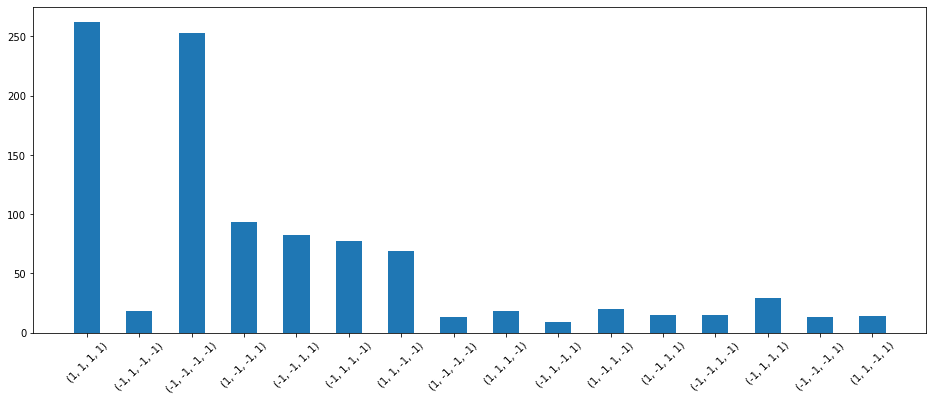

In [89]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits,6))
plt.xticks(rotation=45)
x_axis = []
for key in dict_outcomes:
    x_axis.append(str(key))
plt.bar(x_axis, dict_outcomes.values(), width = 0.5)